In [18]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import math
from math import sqrt, pi
from numpy import cos, exp, sin
import pybinding as pb
from pybinding.repository import graphene
a=graphene.a
a_cc=graphene.a_cc

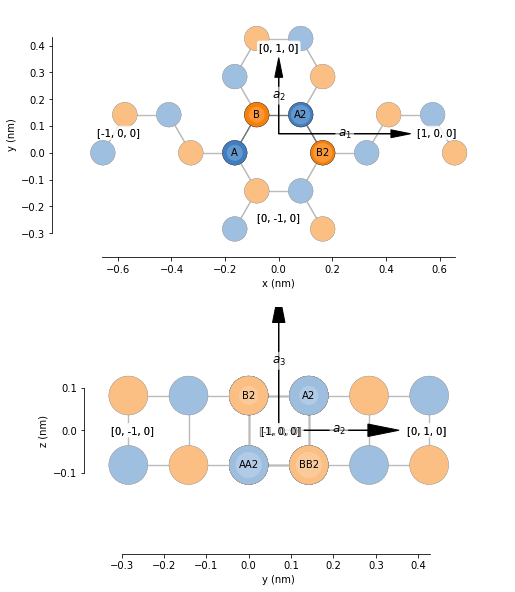

In [19]:
def bilayer_8atom(onsite=(0, 0)):
    """Nearest-neighbor with 4 atoms per unit cell: square lattice instead of oblique

    Parameters
    ----------
    onsite : Tuple[float, float]
        Onsite energy for sublattices A and B.
    """
    a = graphene.a_cc * 2/sqrt(3)
    a_cc = graphene.a_cc 
    t = graphene.t
    lat = pb.Lattice(a1=[3*a, 0,0], a2=[0, 2* a_cc,0],a3=[0,0,2*a])

    lat.add_sublattices(('A',  [  -a  ,0,a/2], onsite[0]),
                        ('B',  [  -a/2  , a_cc,a/2], onsite[1]))


    lat.add_aliases(('A2', 'A', [  a/2 , a_cc,a/2]),
                    ('B2', 'B', [  a  , 0 ,a/2])
                   ,('BB1','B',[  -a  ,0,-a/2])
                   ,('AA1','A',[-a/2,a_cc,-a/2])
                   ,('BB2','B',[a/2,a_cc,-a/2])
                   ,('AA2','A',[a,0,-a/2]))
    lat.add_hoppings(
        # inside the unit sell
        ([0, 0], 'A',  'B',  t),
        ([0, 0], 'B',  'A2', t),
        ([0, 0], 'A2', 'B2', t),
        ([0, 0], 'BB1', 'AA1', t),
        ([0, 0], 'AA1', 'BB2', t),
        ([0, 0], 'BB2', 'AA2', t),
        ([0, 0], 'A', 'BB1', t),
        ([0, 0], 'B', 'AA1', t),
        ([0, 0], 'A2', 'BB2', t),
        ([0, 0], 'B2', 'AA2', t),
        # between neighbouring unit cells
        ([-1,  0], 'A', 'B2', t),
        ([ 0, -1], 'A', 'B', t),
        ([ 0, -1], 'B2', 'A2', t),
        ([-1,  0], 'BB1', 'AA2', t),
        ([ 0, -1], 'BB1', 'AA1', t),
        ([ 0, -1], 'AA2', 'BB2', t)
        
    )

    lat.min_neighbors = 2
    return lat
fig=plt.figure(figsize=(10,10))
lattice = bilayer_8atom()
lattice.plot(axes='yz')
plt.subplot(211)
lattice.plot()
plt.subplot(212)
lattice.plot(axes='yz')
plt.show()


In [20]:
def gaussian_bump_strain(height, sigma):
    """Out-of-plane deformation (bump)"""
    @pb.site_position_modifier
    def displacement(x, y, z):
        dz = height * np.exp(-(x**2 + y**2) / sigma**2)  # gaussian
        return x, y, z + dz  # only the height changes

    @pb.hopping_energy_modifier
    def strained_hoppings(energy, x1, y1, z1, x2, y2, z2):
        d = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)  # strained neighbor distance
        return energy * np.exp(-3.37 * (d / graphene.a_cc - 1))  # see strain section

    return displacement, strained_hoppings

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


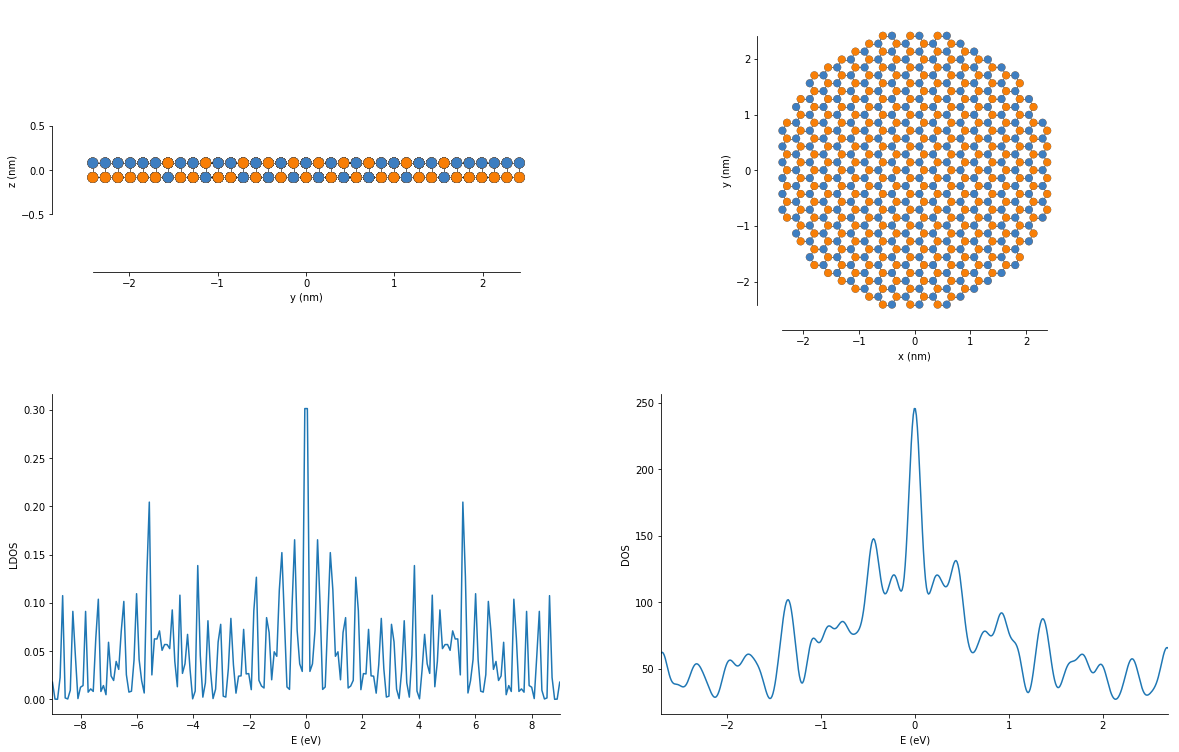

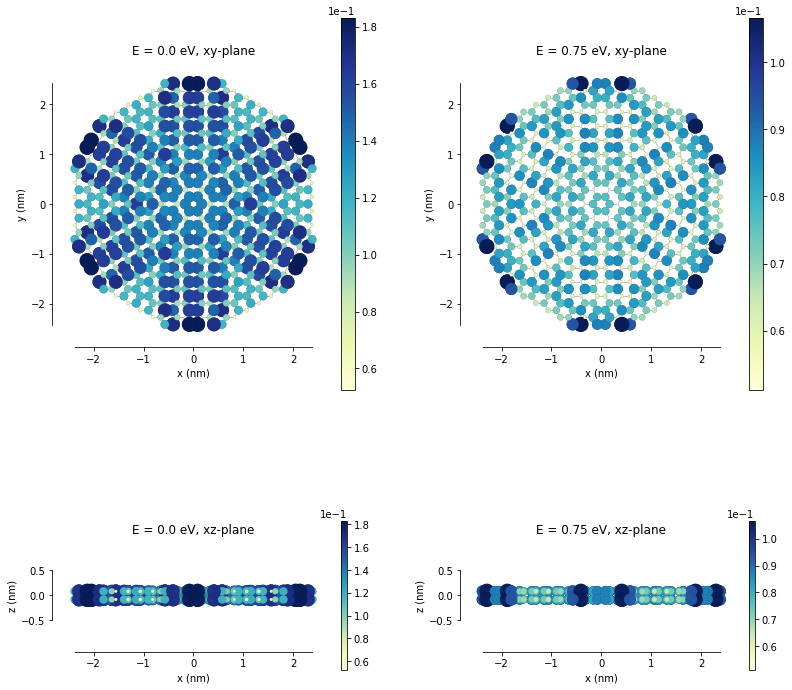

In [21]:
def circle(radius):
    def contains(x, y, z):
        return np.logical_and(np.sqrt(x**2 + y**2) < radius,abs(z)<=a/2)
    return pb.FreeformShape(contains, width=[2*radius, 2*radius])
model1 = pb.Model(#graphene.bilayer()
    lattice
    ,circle(radius=2.5),
   # pb.regular_polygon(num_sides=4, radius=4.5)
    #gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model1.plot(axes='yz')
plt.subplot(322)
model1.plot()
plt.subplot(323)
kpm = pb.kpm(model1)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model1)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model1)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.4], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


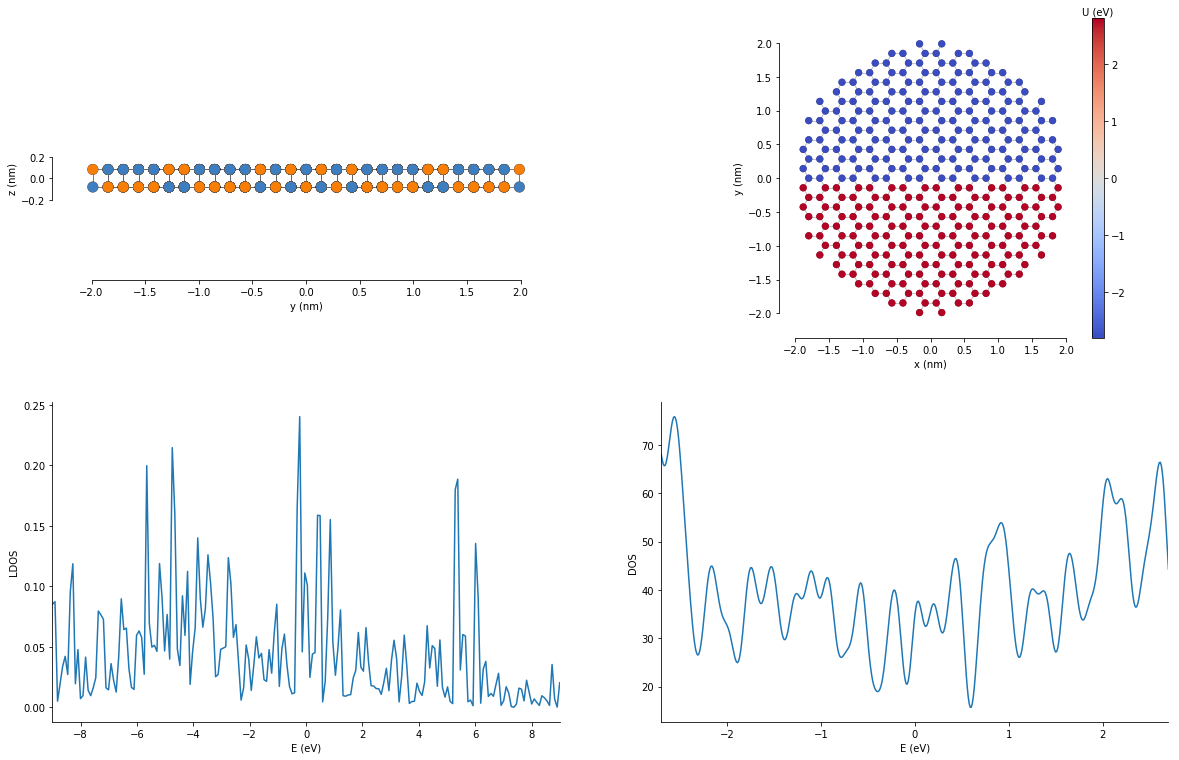

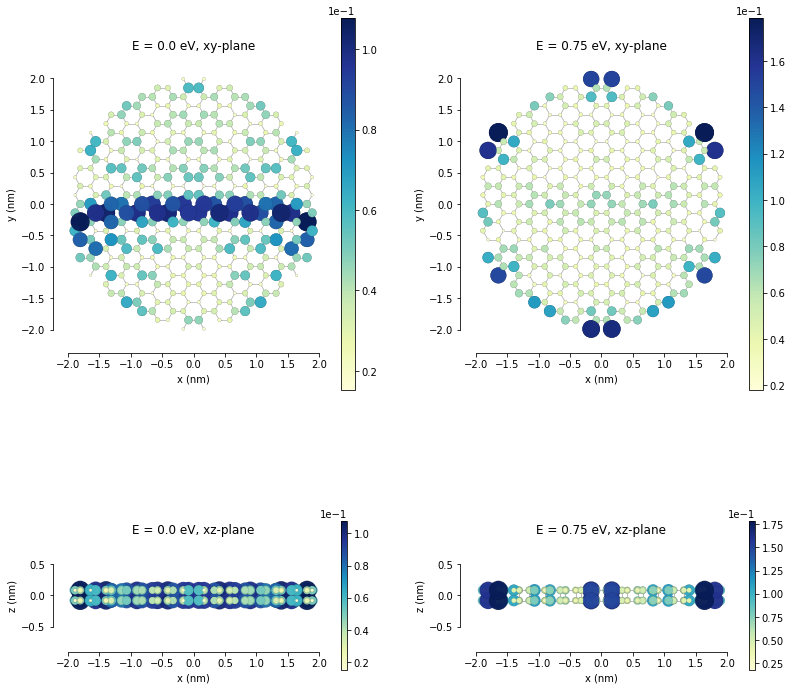

In [22]:
def mass_termy(V1):
#This function makes potential difference along y axes. And it changes suddenly
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy[y>=0] += V1
        energy[y<0] -= V1
        return energy
    
    return potential
model2 = pb.Model(#graphene.bilayer()
    lattice,
    mass_termy(graphene.t),
    #pb.translational_symmetry(),
    circle(radius=2)
    #donut(radius=2),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    #gaussian_bump_strain(height=1.6, sigma=1.6)
)
fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model2.plot(axes='yz')
plt.subplot(322)
model2.onsite_map.plot(cmap="coolwarm", site_radius=0.04,num_periods=0)
pb.pltutils.colorbar(label="U (eV)")
plt.subplot(323)
kpm = pb.kpm(model2)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model2)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model2)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.4], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


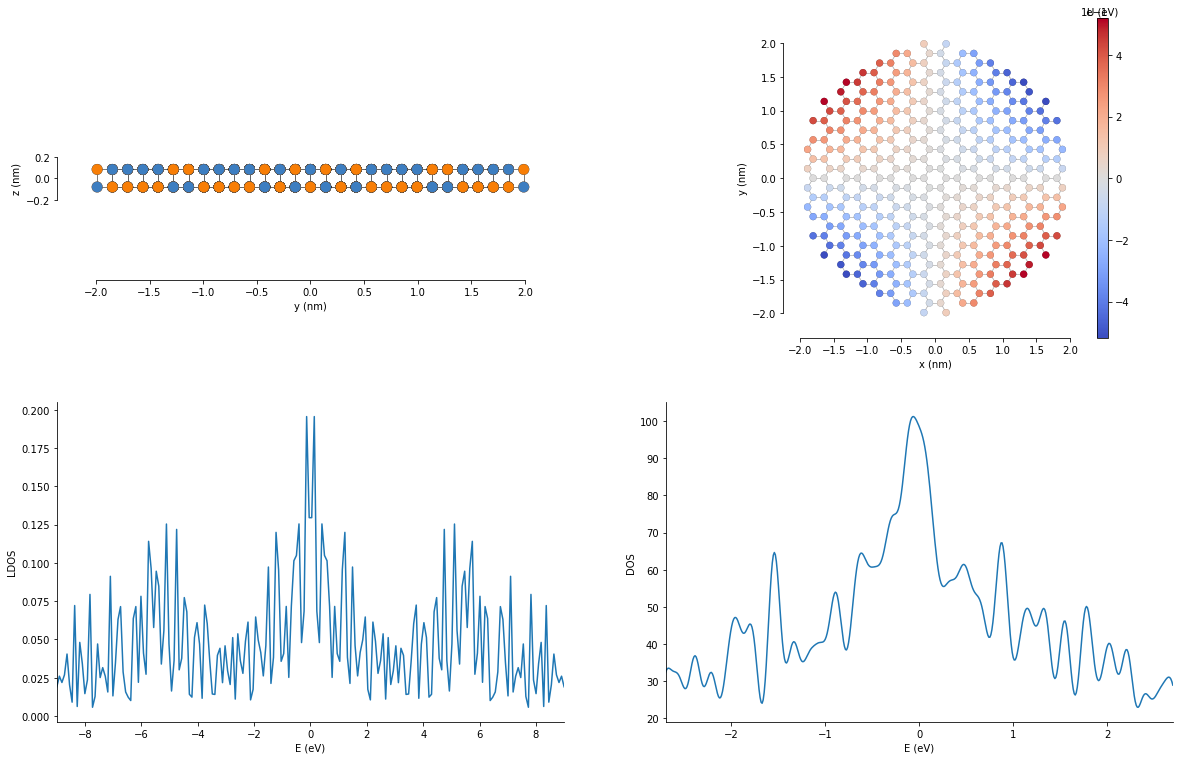

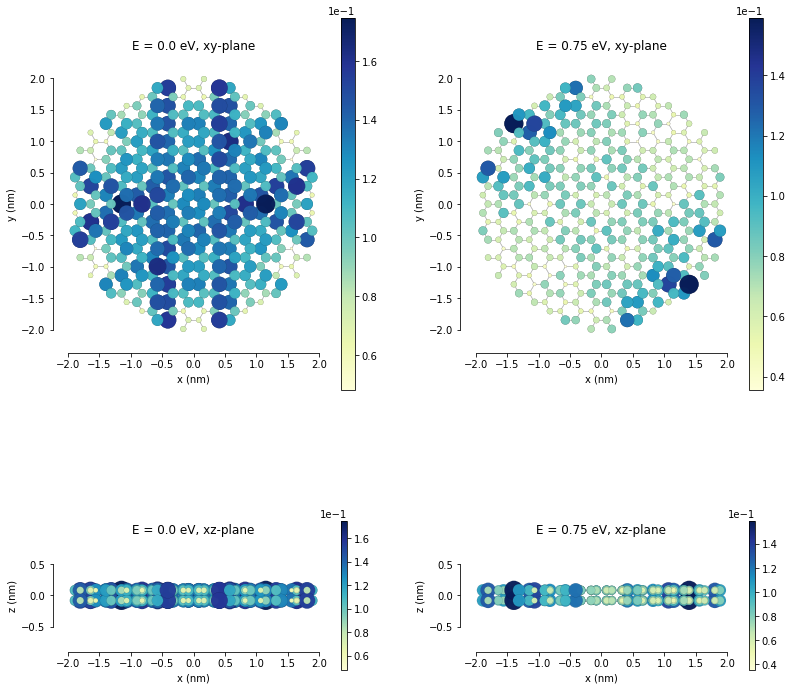

In [23]:
def mass_term_sinxy(V1):
#potential equals to sin(xy)
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy += V1*sin((x*y)/10)
        return energy
    
    return potential
model3 = pb.Model(#graphene.bilayer()
    lattice,
    mass_term_sinxy(graphene.t),
    #pb.translational_symmetry(),
    circle(radius=2)
    #donut(radius=2),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    #gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model3.plot(axes='yz')
plt.subplot(322)
model3.onsite_map.plot(cmap="coolwarm", site_radius=0.04,num_periods=0)
pb.pltutils.colorbar(label="U (eV)")
plt.subplot(323)
kpm = pb.kpm(model3)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model3)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model3)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.4], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


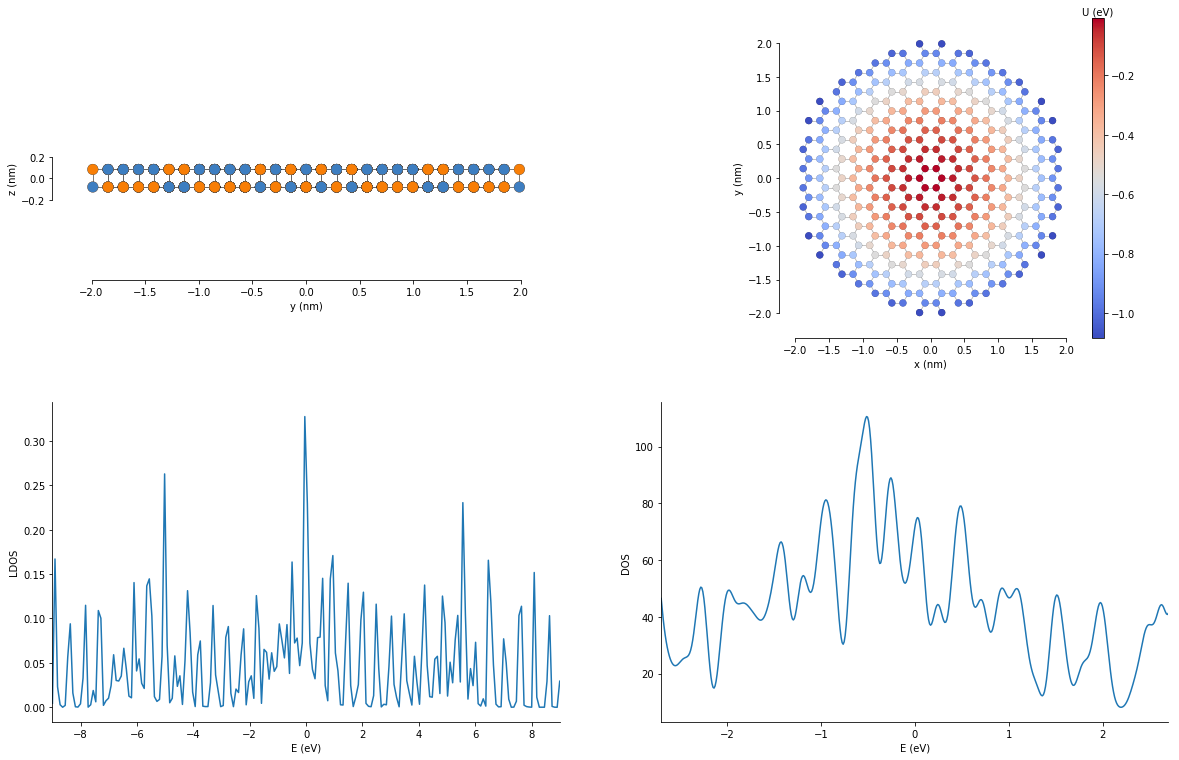

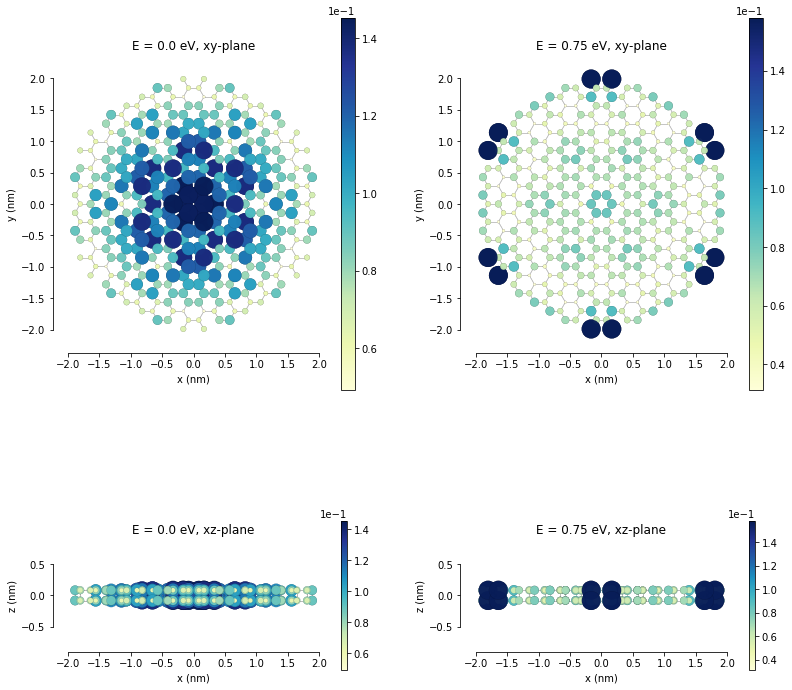

In [24]:
def mass_term_sinxxyy(V1):
#potential equals to sin(x^2+y^2)
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy += V1*sin((x**2+y**2)/10)
        return energy
    
    return potential
model4 = pb.Model(#graphene.bilayer()
    lattice,
    mass_term_sinxxyy(graphene.t),
    #pb.translational_symmetry(),
    circle(radius=2)
    #donut(radius=2),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    #gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model4.plot(axes='yz')
plt.subplot(322)
model4.onsite_map.plot(cmap="coolwarm", site_radius=0.04,num_periods=0)
pb.pltutils.colorbar(label="U (eV)")
plt.subplot(323)
kpm = pb.kpm(model4)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model4)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model4)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.4], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


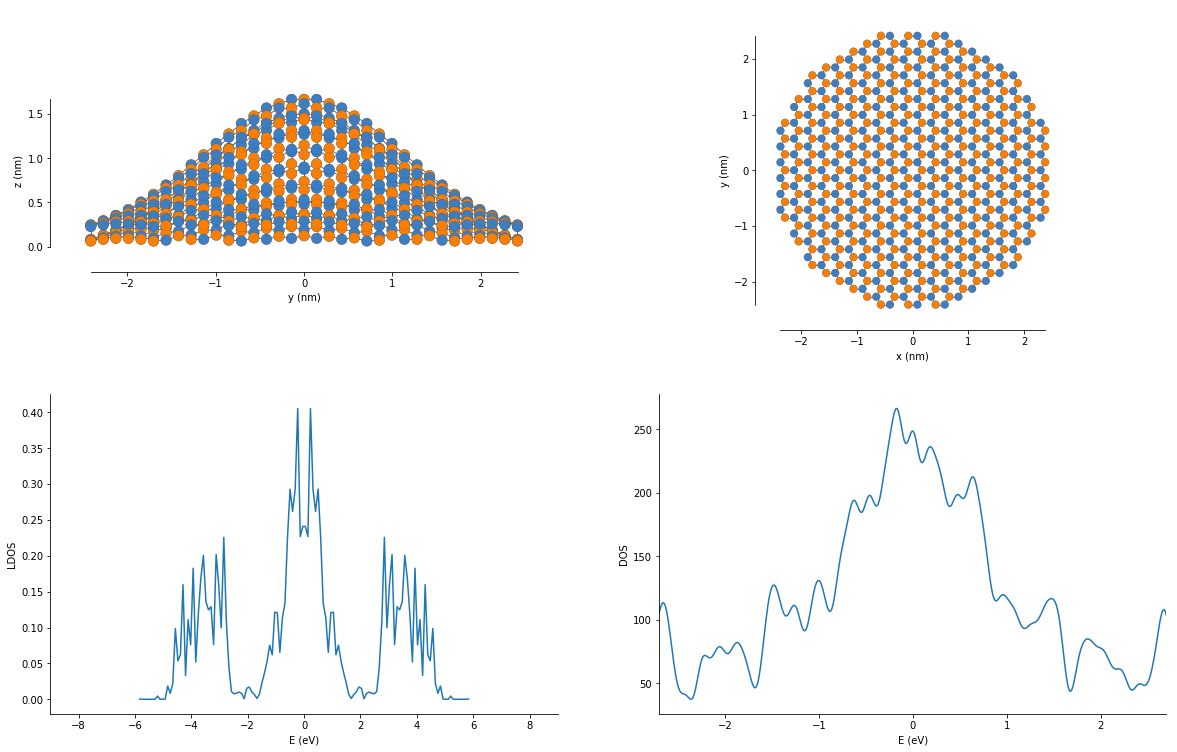

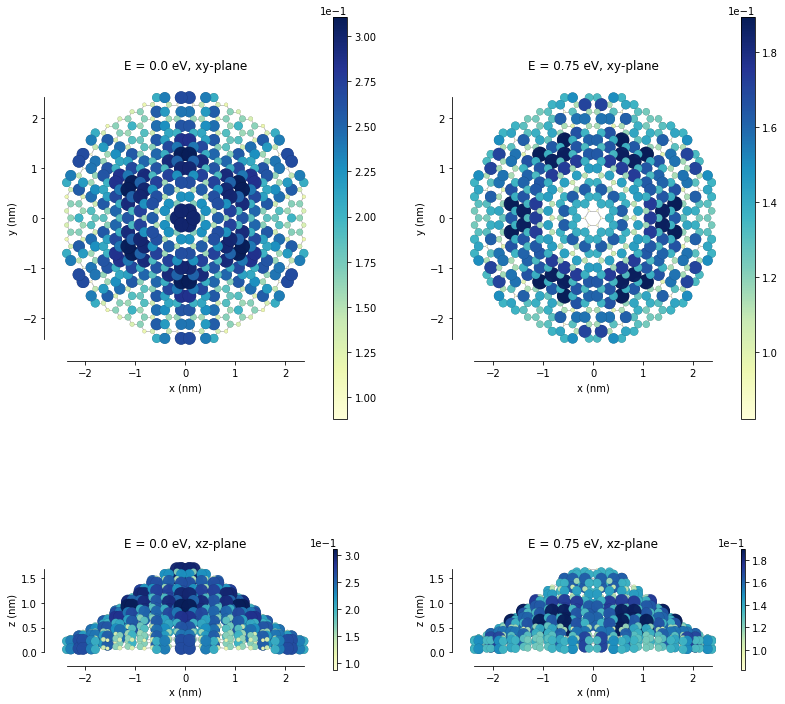

In [25]:
def circle(radius):
    def contains(x, y, z):
        return np.logical_and(np.sqrt(x**2 + y**2) < radius,abs(z)<=a/2)
    return pb.FreeformShape(contains, width=[2*radius, 2*radius])
model5 = pb.Model(#graphene.bilayer()
    lattice,
    #pb.translational_symmetry(),
    circle(radius=2.5),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model5.plot(axes='yz')
plt.subplot(322)
model5.plot()
plt.subplot(323)
kpm = pb.kpm(model5)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model5)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model5)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.3], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


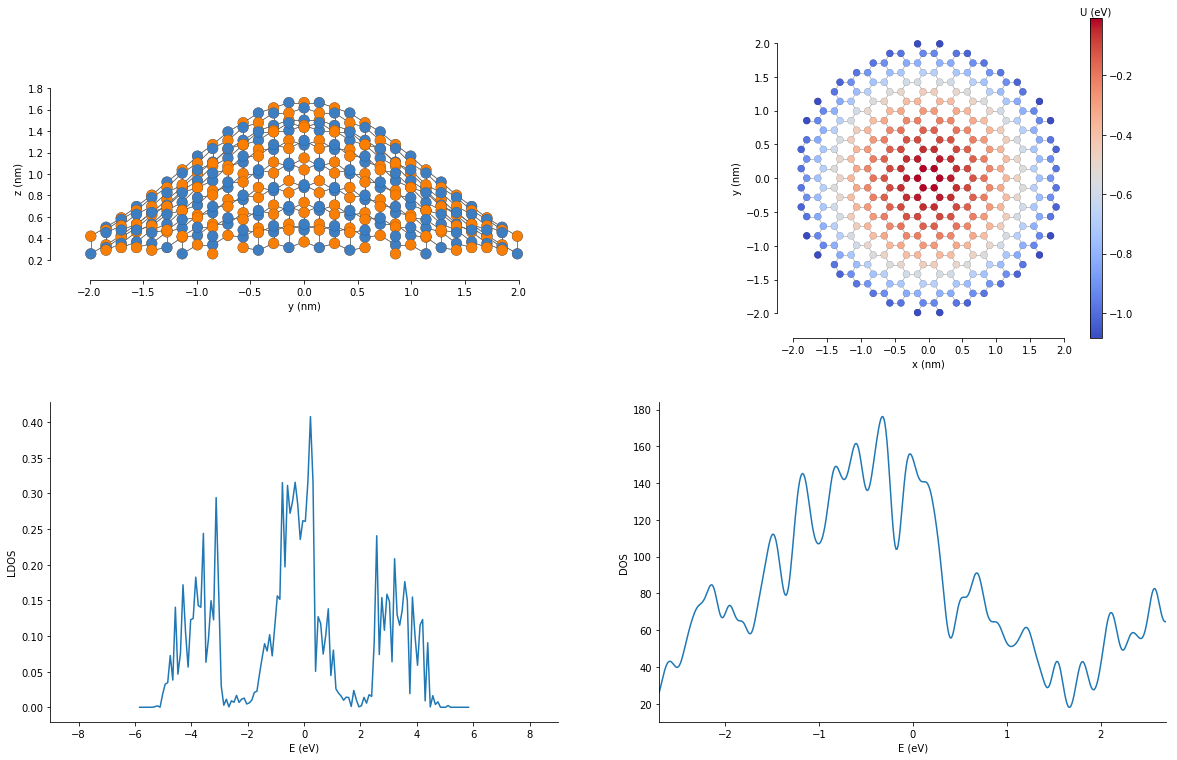

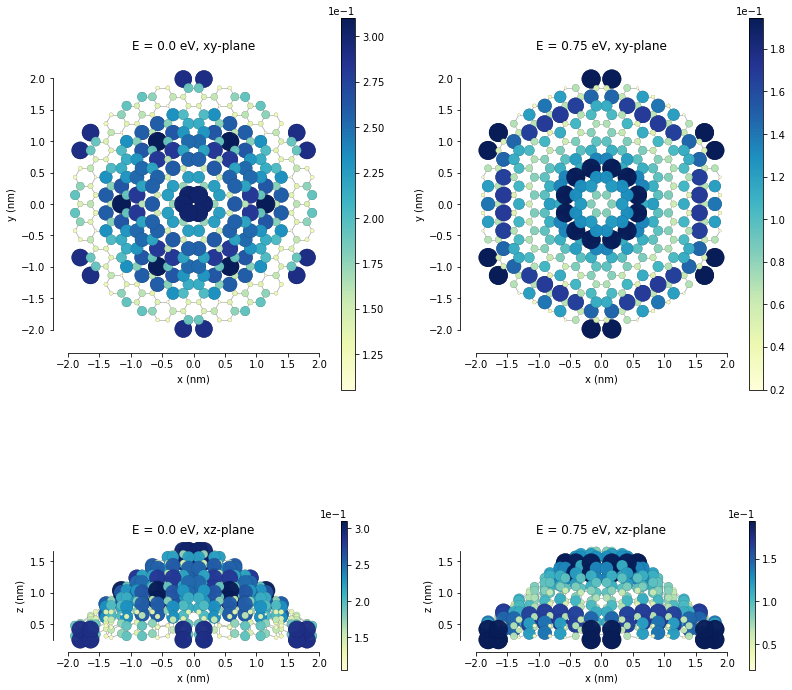

In [26]:
def mass_term_sinxxyy(V1):
#potential equals to sin(x^2+y^2)
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy += V1*sin((x**2+y**2)/10)
        return energy
    
    return potential
model6 = pb.Model(#graphene.bilayer()
    lattice,
    mass_term_sinxxyy(graphene.t),
    #pb.translational_symmetry(),
    circle(radius=2),
    #donut(radius=2),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model6.plot(axes='yz')
plt.subplot(322)
model6.onsite_map.plot(cmap="coolwarm", site_radius=0.04,num_periods=0)
pb.pltutils.colorbar(label="U (eV)")
plt.subplot(323)
kpm = pb.kpm(model6)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model6)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model6)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.4], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

In [27]:
def donut(radius):
    def contains(x, y, z):
        return np.logical_and(np.logical_and(np.sqrt(x**2 + y**2) < radius,abs(z)<=a/2),np.sqrt(x**2+y**2)>radius/6)
    return pb.FreeformShape(contains, width=[2*radius, 2*radius])

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


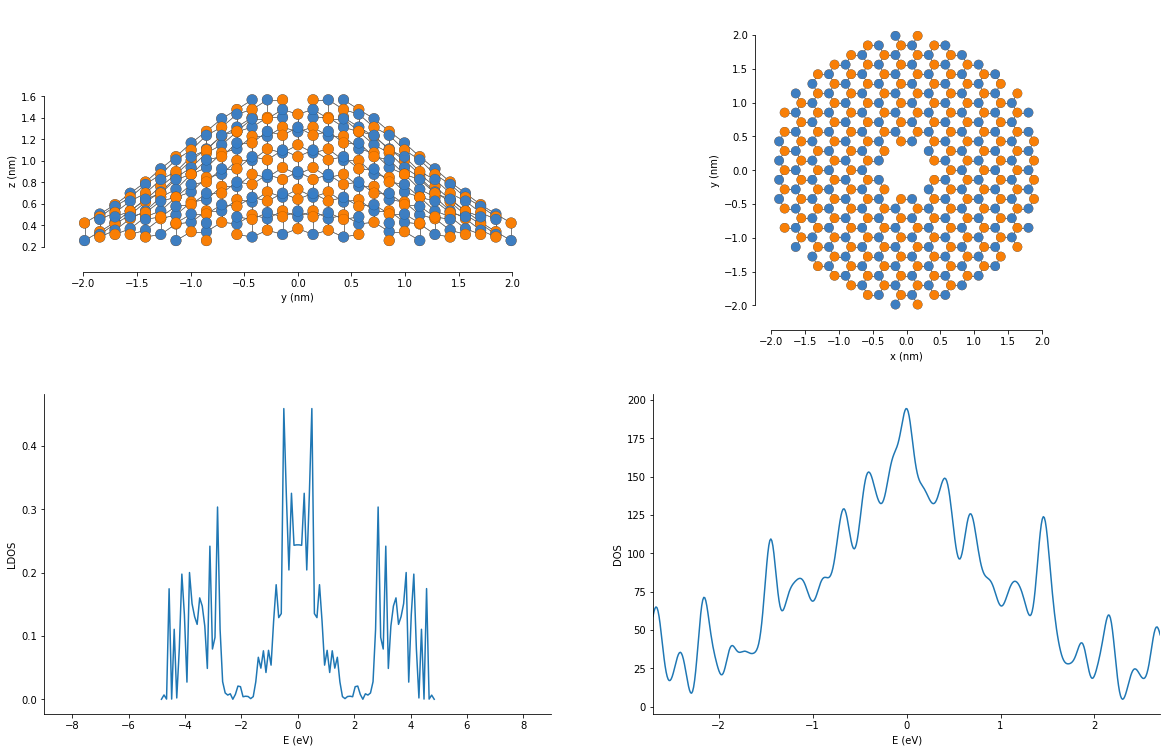

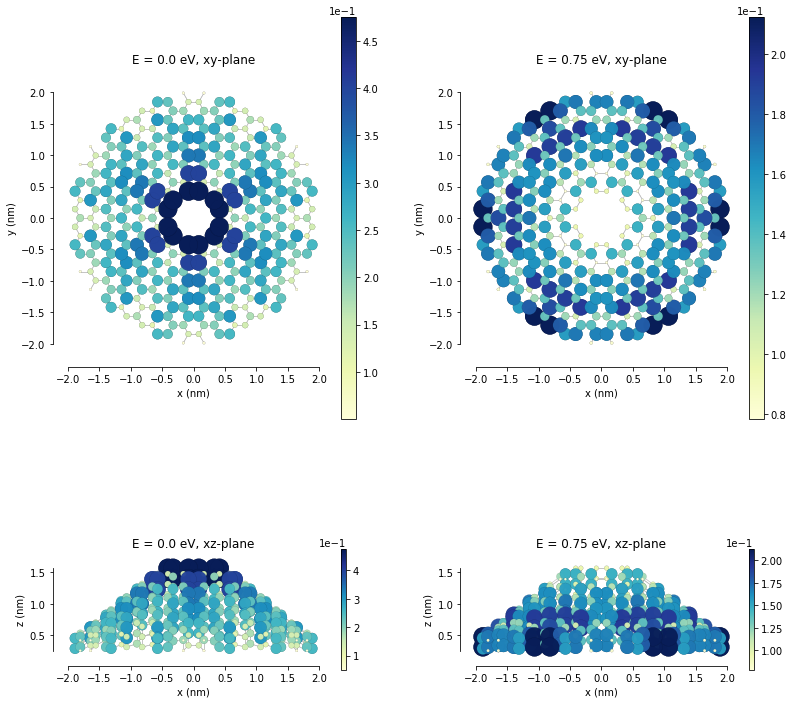

In [28]:
model7 = pb.Model(#graphene.bilayer()
    lattice,
    #pb.translational_symmetry(),
    donut(radius=2),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model7.plot(axes='yz')
plt.subplot(322)
model7.plot()
plt.subplot(323)
kpm = pb.kpm(model7)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model7)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model7)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.3], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


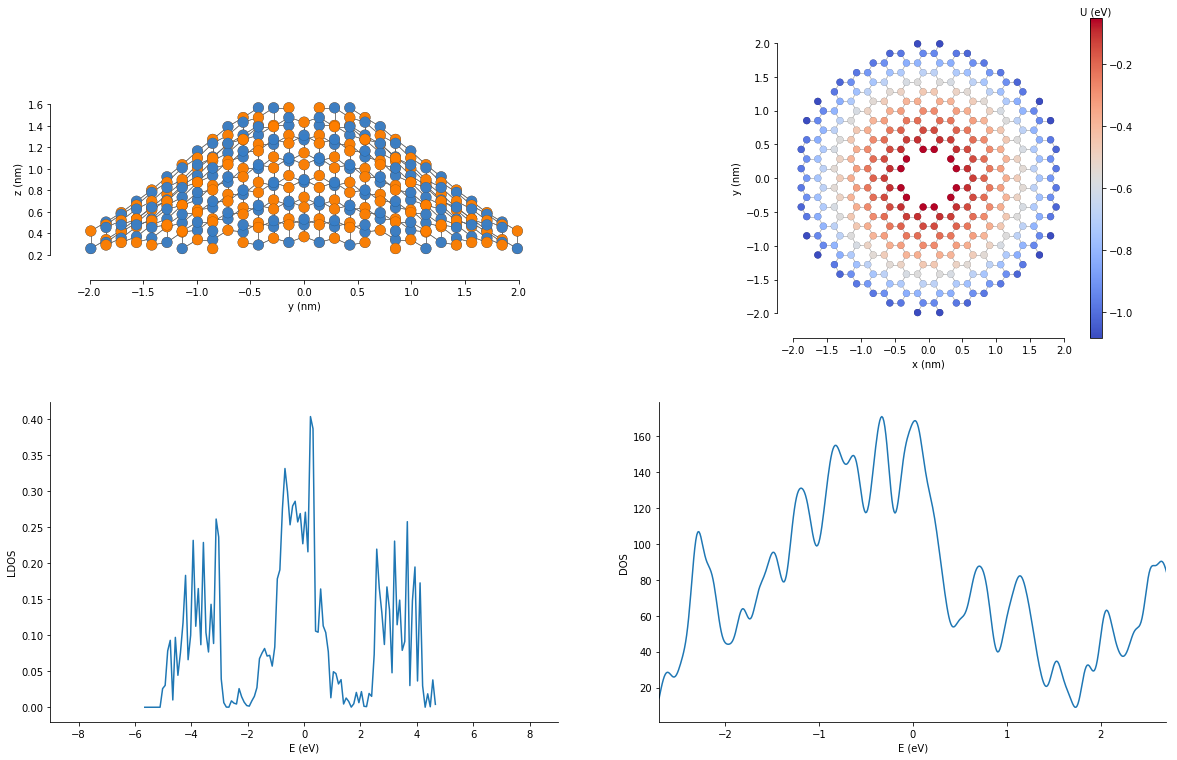

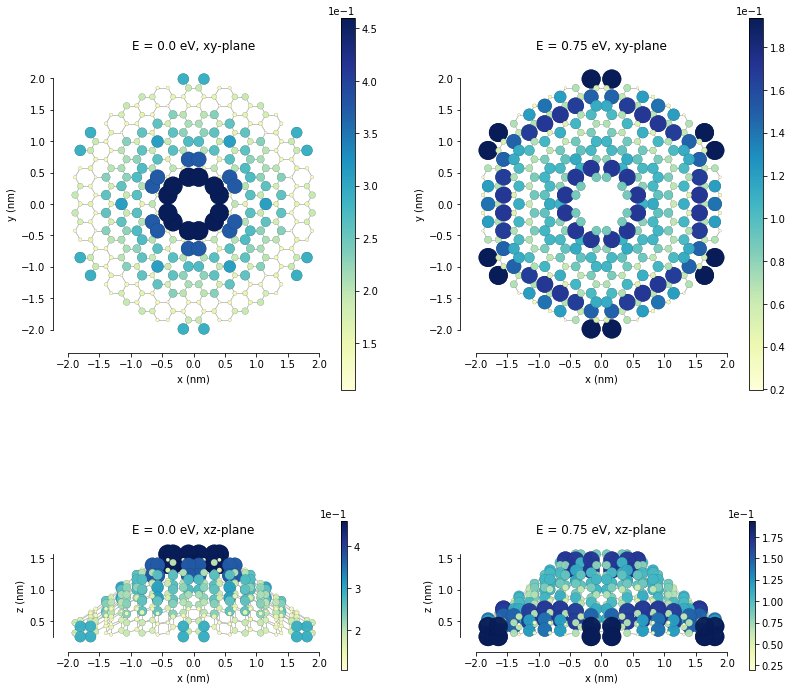

In [29]:
def mass_term_sinxxyy(V1):
#potential equals to sin(x^2+y^2)
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy += V1*sin((x**2+y**2)/10)
        return energy
    
    return potential
model8 = pb.Model(#graphene.bilayer()
    lattice,
    mass_term_sinxxyy(graphene.t),
    #pb.translational_symmetry(),
    #circle(radius=2)
    donut(radius=2),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model8.plot(axes='yz')
plt.subplot(322)
model8.onsite_map.plot(cmap="coolwarm", site_radius=0.04,num_periods=0)
pb.pltutils.colorbar(label="U (eV)")
plt.subplot(323)
kpm = pb.kpm(model8)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model8)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model8)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.4], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


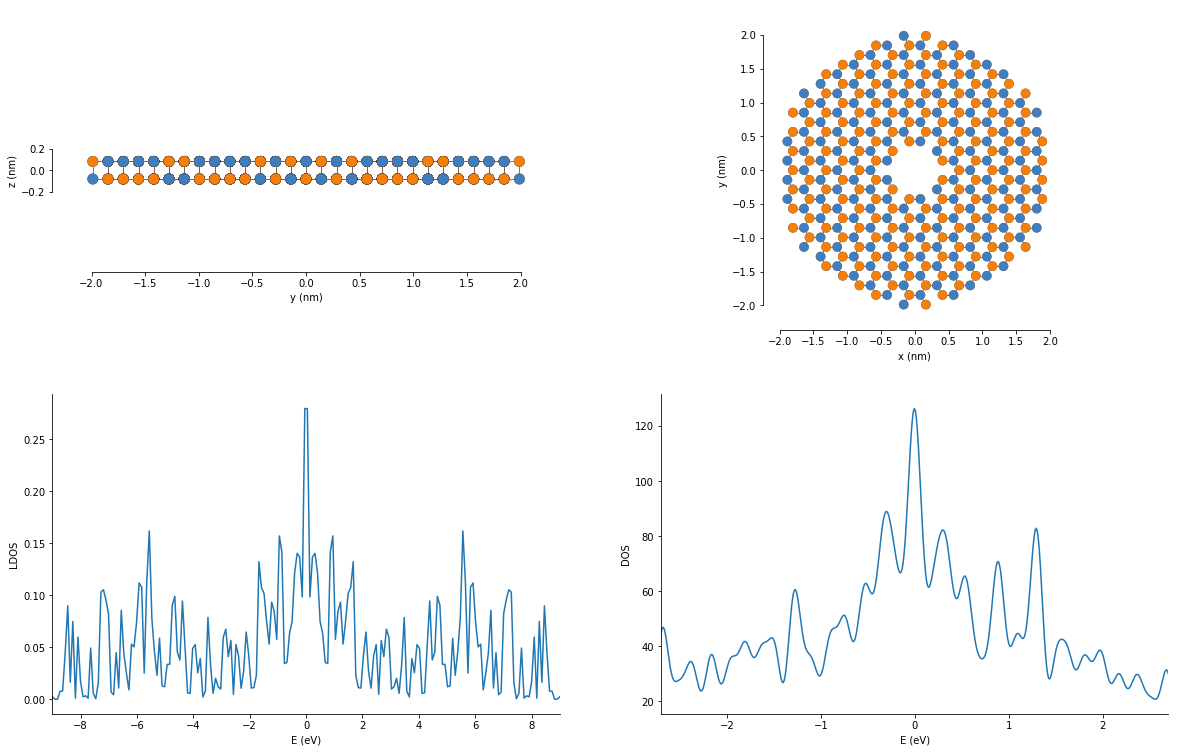

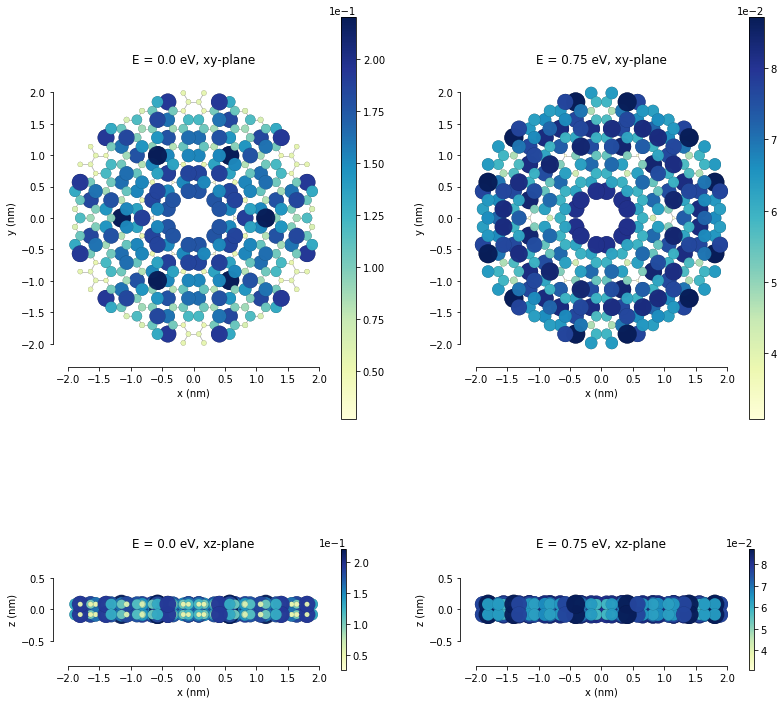

In [30]:
model9 = pb.Model(#graphene.bilayer()
    lattice,
    #pb.translational_symmetry(),
    donut(radius=2),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    #gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model9.plot(axes='yz')
plt.subplot(322)
model9.plot()
plt.subplot(323)
kpm = pb.kpm(model9)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model9)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model9)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.3], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


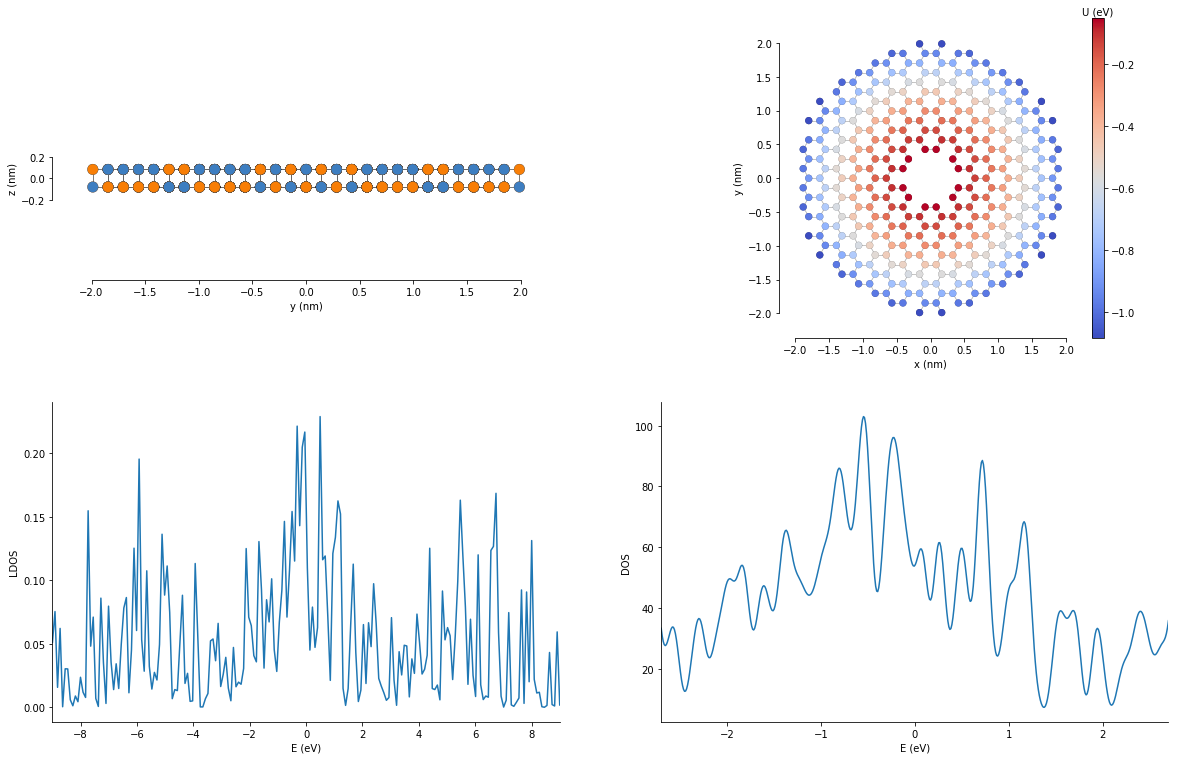

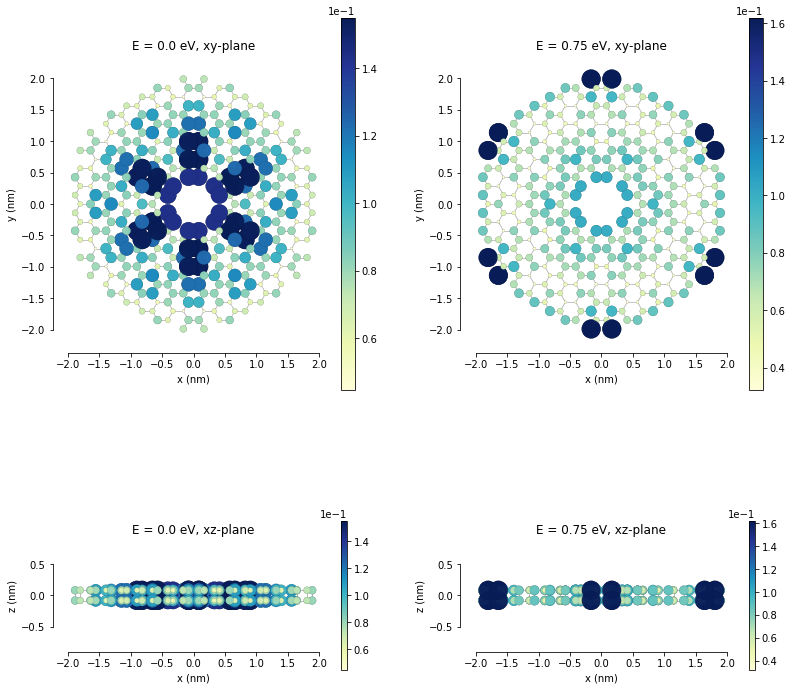

In [31]:
def mass_term_sinxxyy(V1):
#potential equals to sin(x^2+y^2)
    @pb.onsite_energy_modifier

    def potential(energy, sub_id,x,y):
        energy += V1*sin((x**2+y**2)/10)
        return energy
    
    return potential
model10 = pb.Model(#graphene.bilayer()
    lattice,
    mass_term_sinxxyy(graphene.t),
    #pb.translational_symmetry(),
    #circle(radius=2)
    donut(radius=2),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    #gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
plt.subplot(321)
model10.plot(axes='yz')
plt.subplot(322)
model10.onsite_map.plot(cmap="coolwarm", site_radius=0.04,num_periods=0)
pb.pltutils.colorbar(label="U (eV)")
plt.subplot(323)
kpm = pb.kpm(model10)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model10)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model10)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.4], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

In [32]:
plt.figure(figsize=(20,20))

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

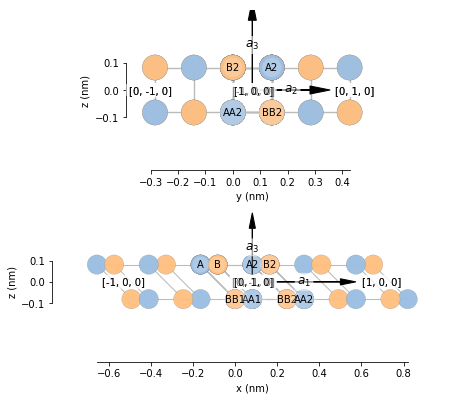

In [33]:
def bilayer_8atom(onsite=(0, 0)):
    """Nearest-neighbor with 4 atoms per unit cell: square lattice instead of oblique

    Parameters
    ----------
    onsite : Tuple[float, float]
        Onsite energy for sublattices A and B.
    """
    a = graphene.a_cc * 2/sqrt(3)
    a_cc = graphene.a_cc 
    t = graphene.t
    lat = pb.Lattice(a1=[3*a, 0,0], a2=[0, 2* a_cc,0],a3=[0,0,2*a])

    lat.add_sublattices(('A',  [  -a  ,0,a/2], onsite[0]),
                        ('B',  [  -a/2  , a_cc,a/2], onsite[1]))


    lat.add_aliases(('A2', 'A', [  a/2 , a_cc,a/2]),
                    ('B2', 'B', [  a  , 0 ,a/2])
                   ,('BB1','B',[  0  ,0,-a/2])
                   ,('AA1','A',[a/2,a_cc,-a/2])
                   ,('BB2','B',[3*a/2,a_cc,-a/2])
                   ,('AA2','A',[2*a,0,-a/2]))
    lat.add_hoppings(
        # inside the unit sell
        ([0, 0], 'A',  'B',  t),
        ([0, 0], 'B',  'A2', t),
        ([0, 0], 'A2', 'B2', t),
        ([0, 0], 'BB1', 'AA1', t),
        ([0, 0], 'AA1', 'BB2', t),
        ([0, 0], 'BB2', 'AA2', t),
        ([0, 0], 'A', 'BB1', t),
        ([0, 0], 'B', 'AA1', t),
        ([0, 0], 'A2', 'BB2', t),
        ([0, 0], 'B2', 'AA2', t),
        # between neighbouring unit cells
        ([-1,  0], 'A', 'B2', t),
        ([ 0, -1], 'A', 'B', t),
        ([ 0, -1], 'B2', 'A2', t),
        ([-1,  0], 'BB1', 'AA2', t),
        ([ 0, -1], 'BB1', 'AA1', t),
        ([ 0, -1], 'AA2', 'BB2', t)
        
    )

    lat.min_neighbors = 2
    return lat
fig=plt.figure(figsize=(10,10))
lattice = bilayer_8atom()
lattice.plot(axes='yz')
plt.subplot(311)
lattice.plot(axes='yz')
plt.subplot(312)
lattice.plot(axes='xz')
plt.show()


Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00


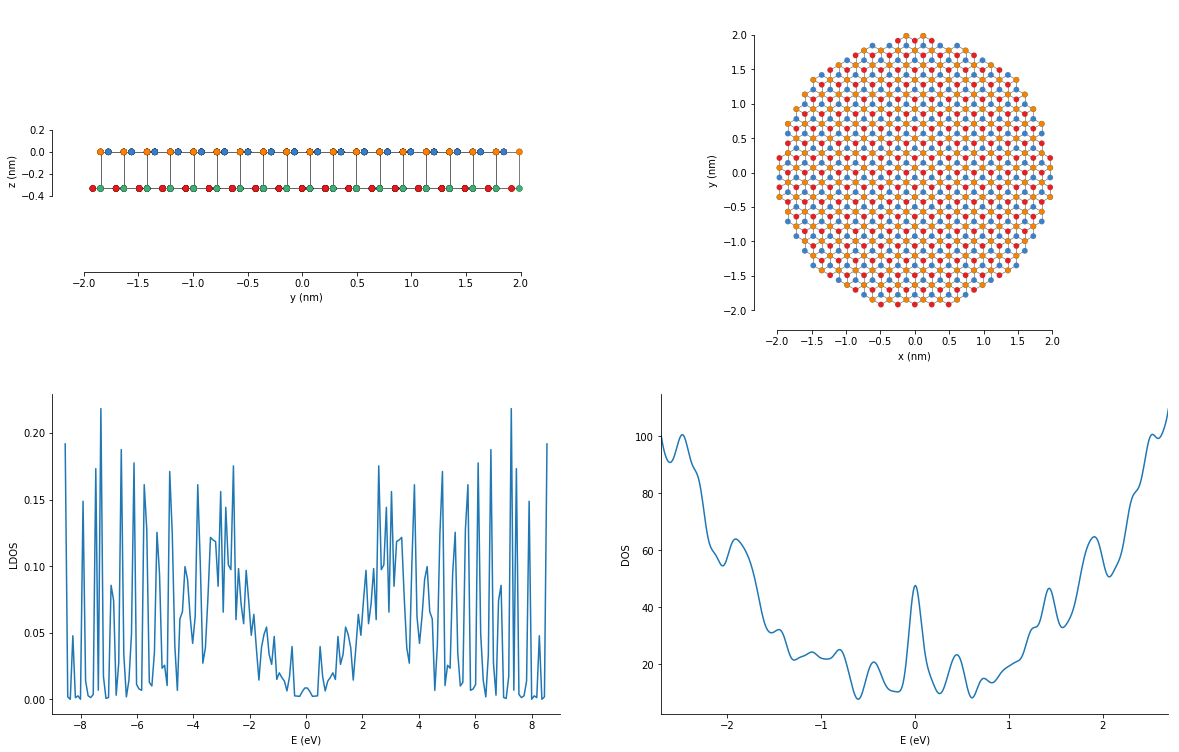

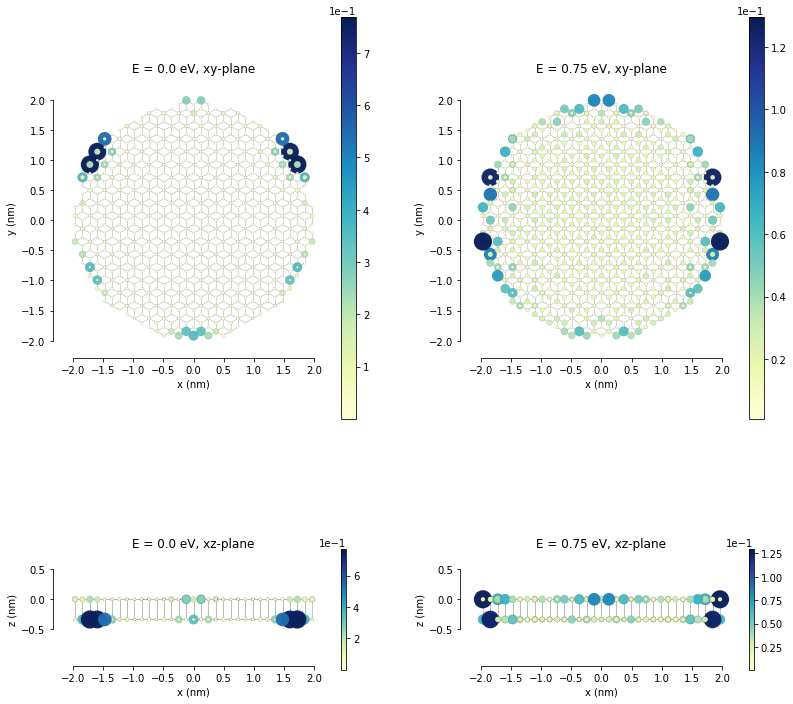

In [67]:
def circle(radius):
    def contains(x, y, z):
        return np.sqrt(x**2 + y**2) < radius
    return pb.FreeformShape(contains, width=[2*radius, 2*radius])
model = pb.Model(#lattice,
    graphene.bilayer(),
    #pb.translational_symmetry(),
    circle(radius=2),
    #,pb.regular_polygon(num_sides=4, radius=4.5),
    #gaussian_bump_strain(height=1.6, sigma=1.6)
)

fig=plt.figure(figsize=(20,20))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.3], hspace=0.5)
plt.subplot(321)
model.plot(axes='yz')
plt.subplot(322)
model.plot()
plt.subplot(323)
kpm = pb.kpm(model)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
kpm = pb.kpm(model)
plt.subplot(324)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
kpm = pb.kpm(model)
spatial_ldos = kpm.calc_spatial_ldos(energy=np.linspace(-3, 3, 100), broadening=0.2,  # eV
                                     shape=pb.circle(radius=2.8))  # only within the shape
plt.figure(figsize=(13.4, 12))
gridspec = plt.GridSpec(2, 2, height_ratios=[1, 0.3], hspace=0.5)

energies = [0.0, 0.75, 0.0, 0.75]  # eV
planes = ["xy", "xy", "xz", "xz"]

for g, energy, axes in zip(gridspec, energies, planes):
    plt.subplot(g, title="E = {} eV, {}-plane".format(energy, axes))
    smap = spatial_ldos.structure_map(energy)
    smap.plot(site_radius=(0.02, 0.15), axes=axes)
    pb.pltutils.colorbar()#label="U(eV)")

Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [////////////////////////////////] Elapsed: 0:00:00 / ETA: 0:00:00
Computing KPM moments...
Progress 100% [//////

Text(0.5, 1.0, 'donut bilayer')

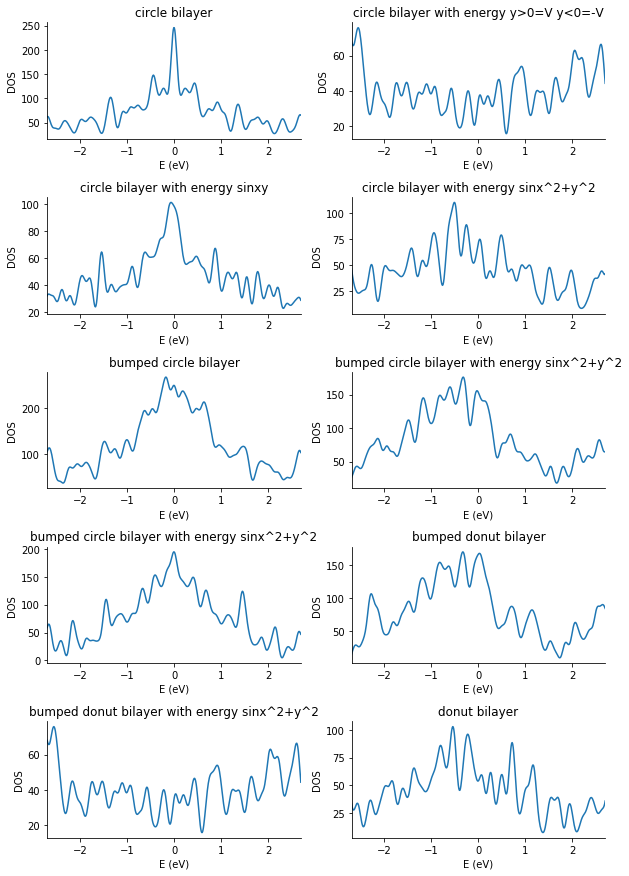

In [82]:
fig=plt.figure(figsize=(10,15))
plt.title('Dos')
plt.subplots_adjust(hspace=0.5)
plt.subplot(521)
kpm = pb.kpm(model1)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
plt.title('circle bilayer')
plt.subplot(522)
kpm = pb.kpm(model2)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
plt.title('circle bilayer with energy y>0=V y<0=-V')
plt.subplot(523)
kpm = pb.kpm(model3)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
plt.title('circle bilayer with energy sinxy')
dos.plot()
plt.subplot(524)
kpm = pb.kpm(model4)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
plt.title('circle bilayer with energy sinx^2+y^2')
plt.subplot(525)
kpm = pb.kpm(model5)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
plt.title('bumped circle bilayer')
plt.subplot(526)
kpm = pb.kpm(model6)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
plt.title('bumped circle bilayer with energy sinx^2+y^2')
plt.subplot(527)
kpm = pb.kpm(model7)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
plt.title('bumped circle bilayer with energy sinx^2+y^2')
plt.subplot(528)
kpm = pb.kpm(model8)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
plt.title('bumped donut bilayer')
plt.subplot(529)
kpm = pb.kpm(model2)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
plt.title('bumped donut bilayer with energy sinx^2+y^2')
plt.subplot(5,2,10)
kpm = pb.kpm(model10)
dos = kpm.calc_dos(energy=np.linspace(-2.7, 2.7, 500), broadening=0.06, num_random=16)
dos.plot()
plt.title('donut bilayer')


Text(0.5, 1.0, 'doughnut bilayer')

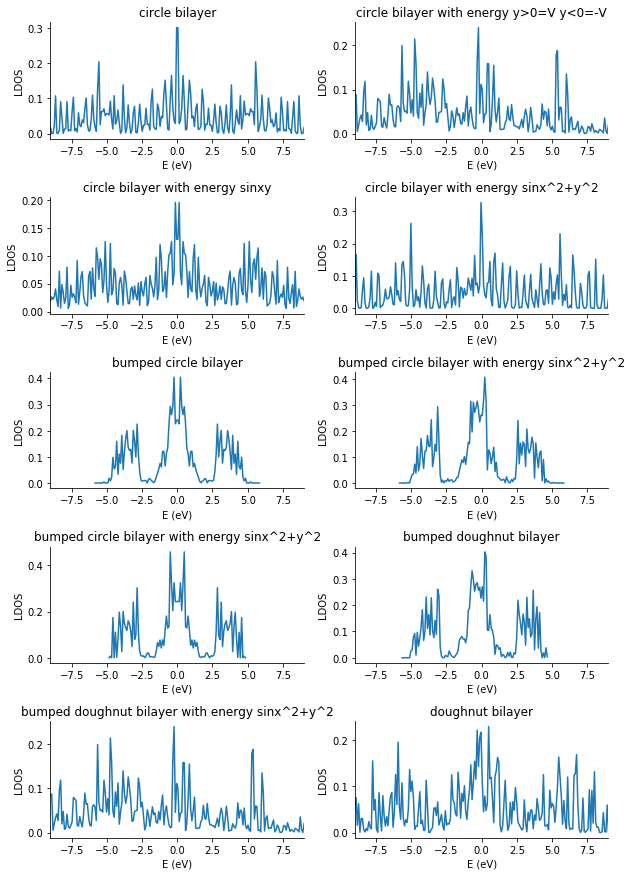

In [87]:

fig=plt.figure(figsize=(10,15))

plt.subplots_adjust(hspace=0.5)
plt.subplot(521)
kpm = pb.kpm(model1)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
plt.title('circle bilayer')
plt.subplot(522)
kpm = pb.kpm(model2)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
plt.title('circle bilayer with energy y>0=V y<0=-V')
plt.subplot(523)
kpm = pb.kpm(model3)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
plt.title('circle bilayer with energy sinxy')
ldos.plot()
plt.subplot(524)
kpm = pb.kpm(model4)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
plt.title('circle bilayer with energy sinx^2+y^2')
plt.subplot(525)
kpm = pb.kpm(model5)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
plt.title('bumped circle bilayer')
plt.subplot(526)
kpm = pb.kpm(model6)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
plt.title('bumped circle bilayer with energy sinx^2+y^2')
plt.subplot(527)
kpm = pb.kpm(model7)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
plt.title('bumped circle bilayer with energy sinx^2+y^2')
plt.subplot(528)
kpm = pb.kpm(model8)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
plt.title('bumped doughnut bilayer')
plt.subplot(529)
kpm = pb.kpm(model2)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
plt.title('bumped doughnut bilayer with energy sinx^2+y^2')
plt.subplot(5,2,10)
kpm = pb.kpm(model10)
ldos = kpm.calc_ldos(energy=np.linspace(-9, 9, 200), broadening=0.05, position=[0, 0])
ldos.plot()
plt.title('doughnut bilayer')
